---
# Create MOM6 bathymetry files for CESM3 LGM
### Author: Jiang Zhu (jiangzhu@ucar.edu)

* Tools used
  * [mom6_bathy](https://ncar.github.io/mom6_bathy/index.html) by Alper Altuntas
* Other references
  * [Notebook](https://github.com/NCAR/tx2_3/blob/main/topography/MaskEdit_tx2_3v2b.ipynb) for preindustrial files by Gustavo Marques et al.
  * [MOM6 supergrid](https://mom6.readthedocs.io/en/main/api/generated/pages/Discrete_Grids.html)
---

In [1]:
import subprocess
import datetime

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature

from mom6_bathy.grid import Grid
from mom6_bathy.topo import Topo

import warnings
warnings.filterwarnings('ignore')

---
# Input

In [2]:
mom_supergird = '/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/ocean_hgrid_221123.nc'
mom_topog = '/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/ocean_topog_230413.nc'

pop_21ka = '/glade/work/jiangzhu/data/pop_grid_kmt_rmask_gx1v7_21ka.240322.nc'

i6g_21ka = '/glade/campaign/cesm/development/palwg/raw_boundary_data/ice6g_10min/I6_C.VM5a_10min.21.nc'

---
# Output

In [3]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/campaign/cgd/ppc/jiangzhu/setup_data/mom_topo'
subprocess.run(f"mkdir -p {work_dir}", shell=True)

mom_topog_21ka = f"{work_dir}/ocean_topog_tx2_3v2_230413_21ka_{today}.nc"
cice_grid_21ka = f"{work_dir}/cice_grid_tx2_3v2_230413_21ka_{today}.nc"
mom_mesh_21ka = f"{work_dir}/tx2_3v2_ESMFmesh_230415_21ka_{today}.nc"
mom_scrip_21ka = f"{work_dir}/tx2_3v2_SCRIP_230415_21ka_{today}.nc"

240518


---
# Use mom6_bathy to create MOM6 grid/topo objects from the preindustrial files

In [4]:
grid = Grid.from_supergrid(mom_supergird)
topo = Topo.from_topo_file(grid, mom_topog)

topo.min_depth

0.0

In [5]:
ds_mom_grid = grid.tlat.to_dataset(name='lat')
ds_mom_grid['lon'] = grid.tlon
ds_mom_grid

<xarray.Dataset>
Dimensions:  (ny: 480, nx: 540)
Dimensions without coordinates: ny, nx
Data variables:
    lat      (ny, nx) float64 -81.56 -81.56 -81.56 -81.56 ... 50.27 50.11 49.99
    lon      (ny, nx) float64 -286.7 -286.0 -285.3 -284.7 ... 72.97 72.98 73.0

In [6]:
topo.depth

<xarray.DataArray (ny: 480, nx: 540)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Dimensions without coordinates: ny, nx
Attributes:
    units:    m

In [7]:
topo_min_depth = 10.0
topo.min_depth = topo_min_depth
print(topo.min_depth)

depth_prei = topo.depth
depth_prei

10.0


<xarray.DataArray (ny: 480, nx: 540)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Dimensions without coordinates: ny, nx
Attributes:
    units:    m

---
# Read and plot mom6 preindustrial topography
- MOM6 ocean_topog uses _real_ depth
- MOM6 ocean_topog uses simple 0-1 land-sea mask with _NO marginal seas_

In [8]:
ds_mom_prei = xr.open_dataset(mom_topog)

ds_mom_prei

<xarray.Dataset>
Dimensions:  (lonh: 540, lath: 480, lonq: 541, latq: 481)
Coordinates:
  * lonh     (lonh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * lath     (lath) float64 -81.56 -81.46 -81.36 -81.26 ... 89.33 89.6 89.86
  * lonq     (lonq) float64 -287.0 -286.3 -285.7 -285.0 ... 71.67 72.33 73.0
  * latq     (latq) float64 -81.61 -81.51 -81.41 -81.31 ... 89.46 89.72 89.91
Data variables:
    geolon   (lath, lonh) float64 ...
    geolat   (lath, lonh) float64 ...
    geolonb  (latq, lonq) float64 ...
    geolatb  (latq, lonq) float64 ...
    mask     (lath, lonh) int32 ...
    depth    (lath, lonh) float32 ...
Attributes:
    Description:                       Ocean Topography on MOM6 Grid
    Creator:                           gmarques
    Created:                           20230413
    Generating Code:                   interp_smooth.f90
    Model Grid Version:                tx2_3v2
    Source Topography Data:            /glade/work/bryan/Observations/Topogra...
    Source Mask Data:                  topo.sub150.tx2_3v2.srtm.edit4.nc
    Smoothing Scale L (grid lengths):  1.0
    Smoothing Function:                (L^2 - r^2)/(L^2 + r^2)
    Minimum Depth (m):                 10.0

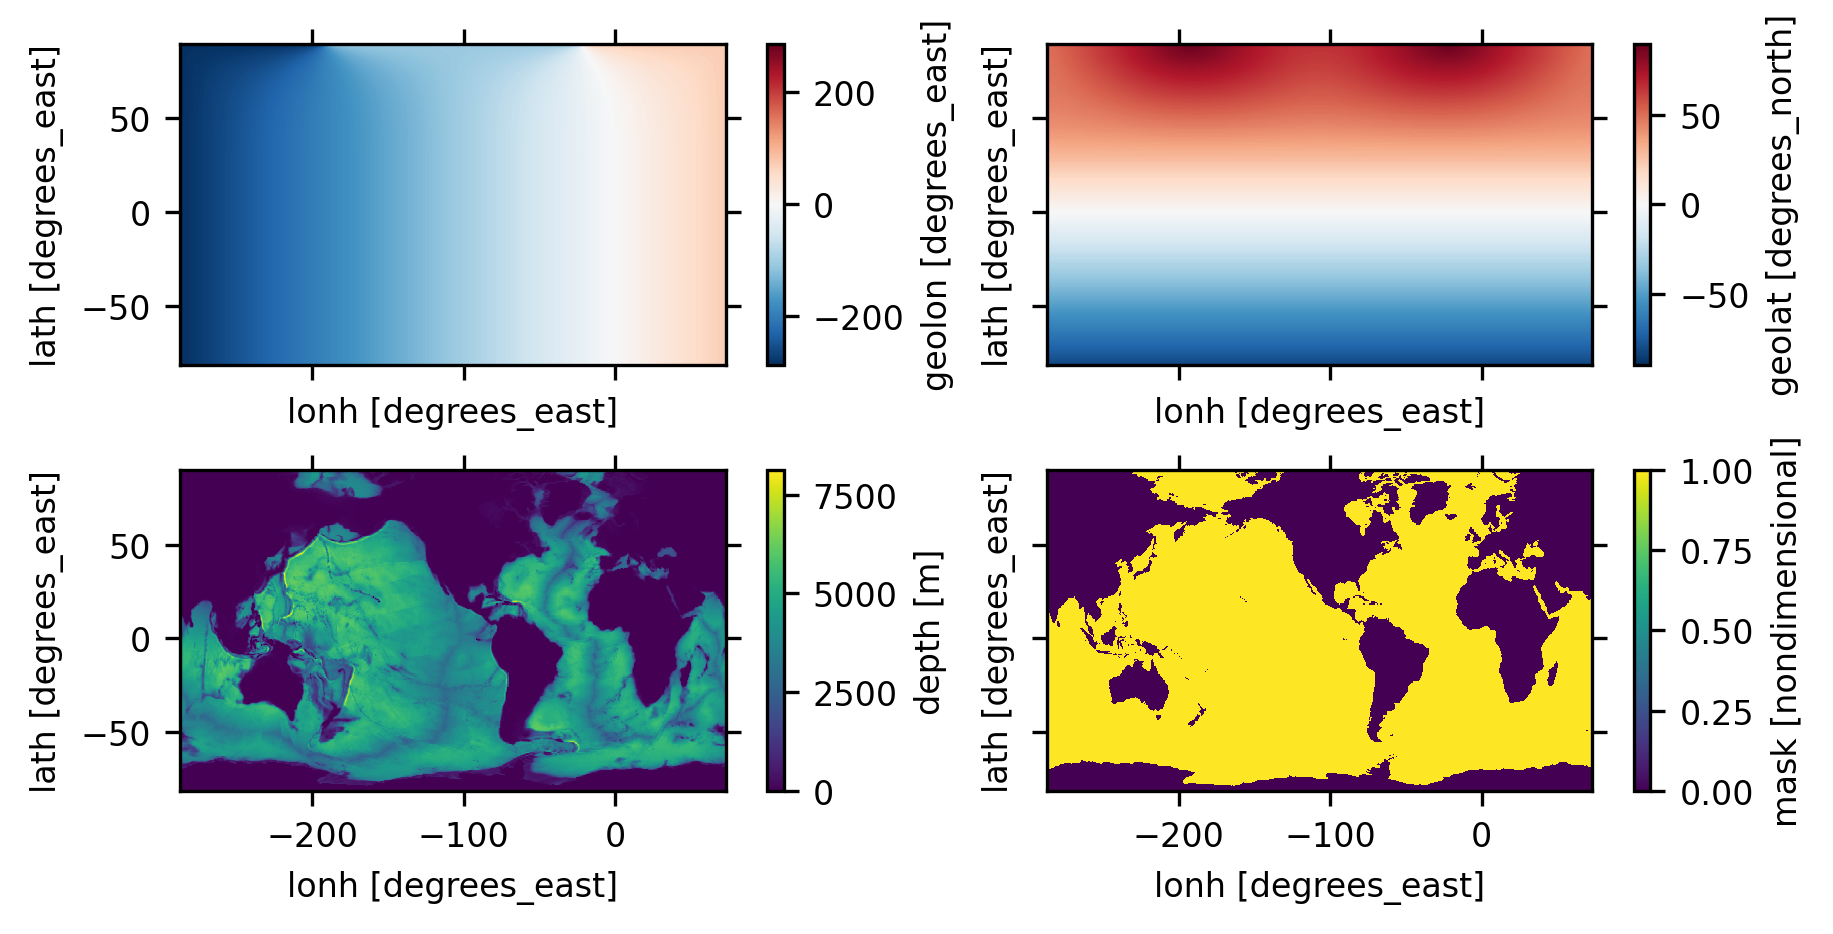

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(6, 3),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, var in zip(axes.ravel(), ['geolon', 'geolat', 'depth', 'mask']):
    ds_mom_prei[var].plot(ax=ax)

---
# Read and plot POP LGM topography
- fixed depth levels (0-60) in POP
- marginal seas in negative index of REGION_MASK

In [10]:
ds_pop_21ka = xr.open_dataset(pop_21ka)
print(f"POP vertical grid in m: {ds_pop_21ka.z_t.values/100}")
ds_pop_21ka

POP vertical grid in m: [5.00000000e+00 1.50000000e+01 2.50000000e+01 3.50000000e+01
 4.50000000e+01 5.50000000e+01 6.50000000e+01 7.50000000e+01
 8.50000000e+01 9.50000000e+01 1.05000000e+02 1.15000000e+02
 1.25000000e+02 1.35000000e+02 1.45000000e+02 1.55000000e+02
 1.65098404e+02 1.75479050e+02 1.86291268e+02 1.97660278e+02
 2.09711379e+02 2.22578285e+02 2.36408829e+02 2.51370163e+02
 2.67654191e+02 2.85483651e+02 3.05119224e+02 3.26867997e+02
 3.51093492e+02 3.78227603e+02 4.08784664e+02 4.43377712e+02
 4.82736729e+02 5.27728001e+02 5.79372891e+02 6.38862622e+02
 7.07563306e+02 7.87002493e+02 8.78825247e+02 9.84705867e+02
 1.10620419e+03 1.24456691e+03 1.40049717e+03 1.57394639e+03
 1.76400324e+03 1.96894419e+03 2.18645653e+03 2.41397155e+03
 2.64900126e+03 2.88938459e+03 3.13340457e+03 3.37979354e+03
 3.62767025e+03 3.87645176e+03 4.12576809e+03 4.37539251e+03
 4.62519029e+03 4.87508346e+03 5.12502805e+03 5.37499982e+03]


<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 14)
Coordinates:
    TLAT         (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
    ULAT         (nlat, nlon) float64 ...
    ULONG        (nlat, nlon) float64 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Dimensions without coordinates: nlat, nlon
Data variables:
    DXT          (nlat, nlon) float64 ...
    DYT          (nlat, nlon) float64 ...
    DXU          (nlat, nlon) float64 ...
    DYU          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    UAREA        (nlat, nlon) float64 ...
    KMT          (nlat, nlon) int32 ...
    REGION_MASK  (nlat, nlon) int32 ...
    dz           (z_t) float64 ...
    region_name  (nreg) <U21 ...
    region_val   (nreg) int64 ...
Attributes:
    lateral_dims:       [384 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4
    type:               dipole
    title:              POP_gx1v6 grid

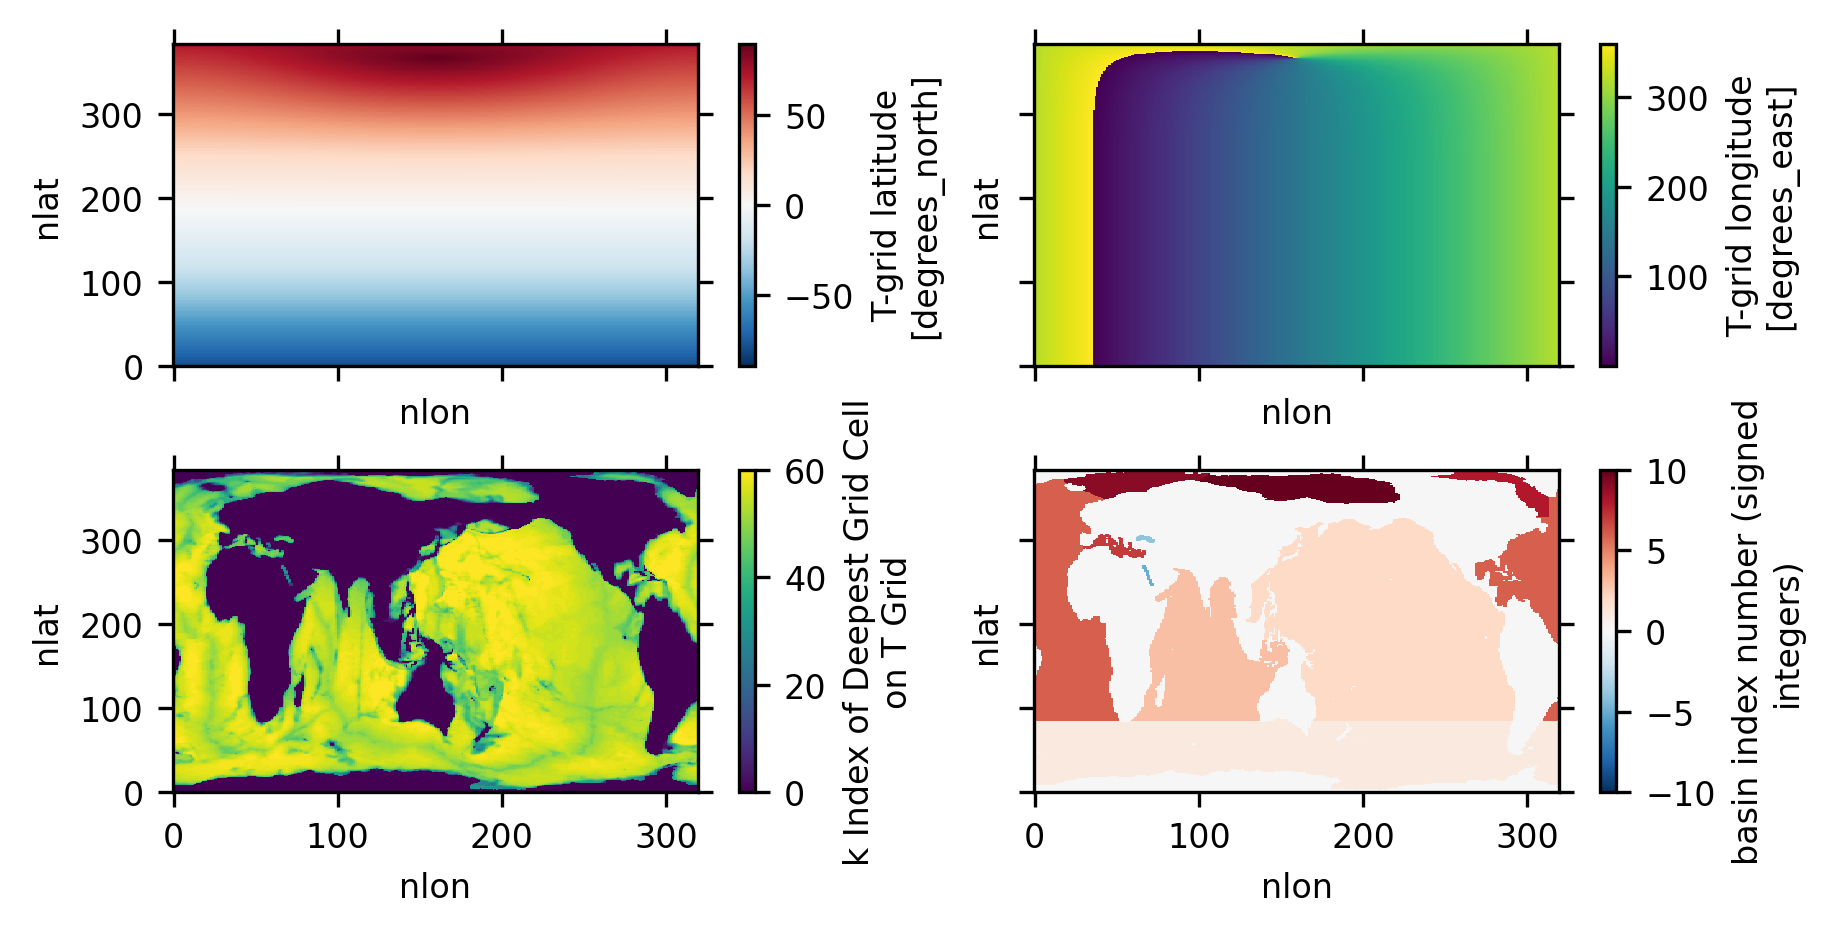

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(6, 3),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, var in zip(axes.ravel(), ['TLAT', 'TLONG', 'KMT', 'REGION_MASK']):
    ds_pop_21ka[var].plot(ax=ax)

---
# Create LGM topo for MOM6 
- Step 1: depth_dSLV --> lower ocean depth by 120 m 
- Step 2: depth_glac --> account for the lgm ice sheets
- Step 3: depth_fill --> run fill_holes to fill "inland" ocean
- Step 4: ds_mom_modi --> further modifications: Sea of Japan, Red Sea, Black Sea ...
- Step 5: save a suite of files that requried for setting up CESM3

### Step 1: Lower ocean depth by 120 m

In [12]:
depth_dSLV = depth_prei.copy(deep=True)

dSLV = -120.0
depth_dSLV = depth_dSLV + dSLV
depth_dSLV = xr.where(depth_dSLV >= topo_min_depth, depth_dSLV, 0)
depth_dSLV

<xarray.DataArray (ny: 480, nx: 540)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Dimensions without coordinates: ny, nx

### Step 2: Fill LGM ocean grid points if covered by ice sheets
- we need to regrid ice-6g to mom grid using xesmf

In [13]:
%%time

i6g_ds = xr.open_dataset(i6g_21ka)
i6g_icef = i6g_ds.sftgif

regridder = xesmf.Regridder(i6g_ds,
                            ds_mom_grid,
                            method="bilinear",
                            periodic=True)
i6g_icef_mom = regridder(i6g_icef)

CPU times: user 36.9 s, sys: 1.18 s, total: 38.1 s
Wall time: 43.7 s


In [14]:
i6g_icef_mom

<xarray.DataArray (ny: 480, nx: 540)>
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)
Dimensions without coordinates: ny, nx
Attributes:
    regrid_method:  bilinear

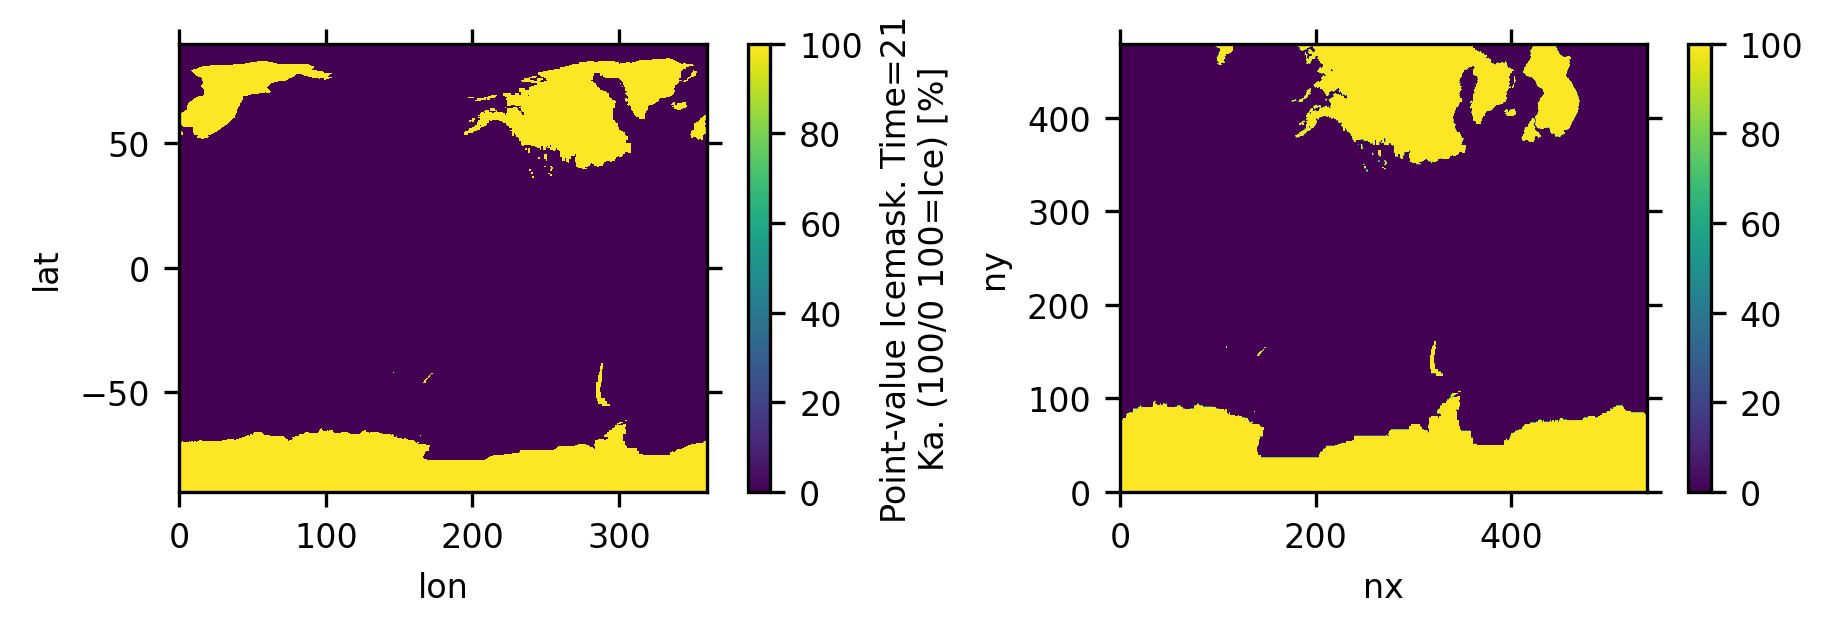

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)
i6g_icef.plot(ax=axes[0])
i6g_icef_mom.plot(ax=axes[1])

In [16]:
i6g_icef_mom = i6g_icef_mom#.rename({"lon": "lonh", "lat": "lath"})

depth_glac = depth_dSLV.copy(deep=True)
depth_glac = xr.where(i6g_icef_mom > 50., 0, depth_glac)
depth_glac

<xarray.DataArray (ny: 480, nx: 540)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Dimensions without coordinates: ny, nx

### Step 3: run fill_holes to fill "inland" ocean

In [17]:
def fill_holes(i, j, field, xcyclic=True, tripolar=True):
    """
    An iterative (stack based) implementation of "Ice 9", used to fill holes

    The flood fill starts at [j,i] and treats any positive value of "field" as
    passable. Zero and negative values block flooding.

    xcyclic = True allows cyclic behavior in the last index. (default)
    tripolar = True allows a fold across the top-most edge. (default)
    """

    field_new = field * 0.
    (nj, ni) = field_new.shape
    stack = set()
    stack.add((j, i))

    while stack:
        (j, i) = stack.pop()

        if field_new[j, i] or field[j, i] <= 0:
            continue
        field_new[j, i] = field[j, i]

        if i > 0:
            stack.add((j, i-1))
        elif xcyclic:
            stack.add((j, ni-1))

        if i < ni-1:
            stack.add((j, i+1))
        elif xcyclic:
            stack.add((j, 0))

        if j > 0:
            stack.add((j-1, i))

        if j < nj-1:
            stack.add((j+1, i))
        elif tripolar:
            stack.add((j, ni-1-i))  # Tri-polar fold

    return field_new

In [18]:
%%time

depth_fill = depth_glac.copy(deep=True)

iseed = 5
jseed = 250
print(f"seeding point depth = {depth_glac[jseed, iseed].values}\n")

depth_fill = fill_holes(iseed, jseed, depth_fill)

seeding point depth = 4656.0390625

CPU times: user 27.5 s, sys: 3.7 ms, total: 27.5 s
Wall time: 30.7 s


### Step 4.0: make plots to examine the results so far
- Prblems: we lost Sea of Japan, Red Sea, and Black Sea due to the "filling" of inland holes
- We need to check important regions such as the Sandal and Sahul shelves

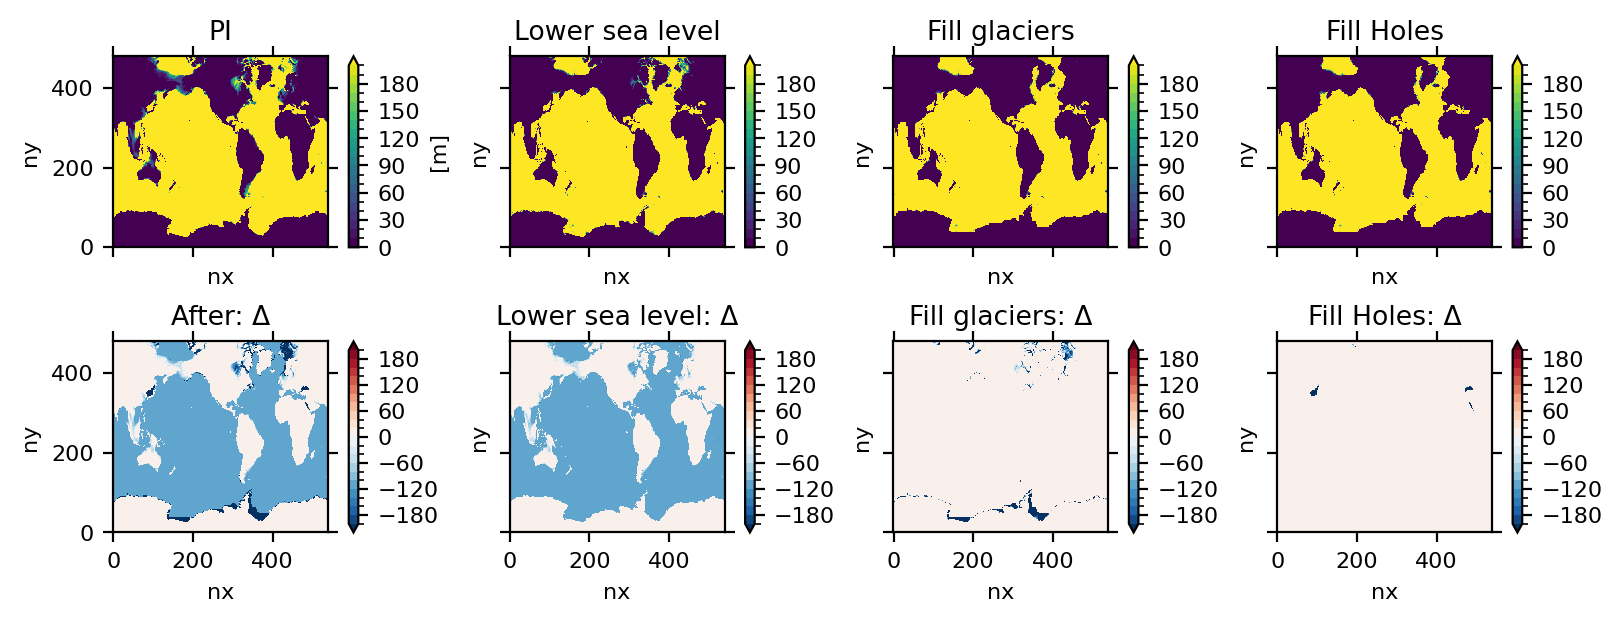

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(8, 3), dpi=200,
                         sharex=True, sharey=True,
                         constrained_layout=True)

for var, title, ax in zip((depth_prei, depth_dSLV,
                           depth_glac, depth_fill),
                          ('PI', 'Lower sea level',
                           'Fill glaciers', 'Fill Holes'),
                          axes.ravel()[0:4]):
    var.plot(ax=ax, levels=np.linspace(0, 200, 21))
    ax.set_title(title)

for var, title, ax in zip((depth_fill - depth_prei,
                           depth_dSLV - depth_prei,
                           depth_glac - depth_dSLV,
                           depth_fill - depth_glac),
                          ('After: Δ',
                           'Lower sea level: Δ',
                           'Fill glaciers: Δ',
                           'Fill Holes: Δ'),
                          axes.ravel()[4:]):
    var.plot(ax=ax, levels=np.linspace(-200, 200, 21),
             extend='both')
    ax.set_title(title)

### Functions used to modify depth and make plots for checking & comparing with POP LGM

In [20]:
def replace_depth_box(depth, depth_to_use, i_bin, j_bin):
    """
    Replace depth in a box (i_bin, j_bin) with depth_to_use
    """

    depth_data = depth.data
    depth_data[i_bin[0]:i_bin[1], j_bin[0]:j_bin[1]] = depth_to_use[i_bin[0]:i_bin[1], j_bin[0]:j_bin[1]]
    depth.data = depth_data

    return depth


def mom6_latlon2ij(lon2D, lat2D, lon, lat, max_iter=10):
    ilast = -1
    jlast = -1

    # Find the equator
    jpt = np.abs(lat2D[:, 0]).argmin().values

    # Handle the wierd MOM6 grids that go past -180
    lo = 0.
    if (lon < lon2D[jpt, :].min()):
        lo = 360.
    if (lon > lon2D[jpt, :].max()):
        lo = -360.

    # Search of the point ageolon grid directions
    ipt = np.abs(lon2D[jpt, :] - (lon+lo)).argmin().values
    n = 0
    while ((ilast != ipt) and (jlast != jpt) and (n < max_iter)):

        lo = 0.
        if (lon < lon2D[jpt, :].min()):
            lo = 360.
        if (lon > lon2D[jpt, :].max()):
            lo = -360.

        ilast = ipt
        jlast = jpt
        jpt = np.abs(lat2D[:, ipt]-lat).argmin().values
        ipt = np.abs(lon2D[jpt, :] - (lon+lo)).argmin().values
        n = n+1
#        print('n=',n,', j,i=',jpt,ip
#              ' lon=',lon2D[jpt,ipt].values,
#              ' lat=',lat2D[jpt,ipt].values,'lo=',lo)
    return ipt, jpt


def plot_depth(depth1, depth2, title1, title2,
               ds_mom_prei, ds_pop_21ka,
               lonbeg, lonend, latbeg, latend, skip=5):

    geolon = ds_mom_prei.geolon
    geolat = ds_mom_prei.geolat

    geolonb = ds_mom_prei.geolonb
    geolatb = ds_mom_prei.geolatb

    fig, axes = plt.subplots(1, 3, figsize=(12, 5),
                             constrained_layout=True,
                             sharex=True, sharey=True,
                             subplot_kw={'projection': ccrs.PlateCarree()})
    plt.set_cmap('PuBuGn')

    for depth, ax, title in zip([depth1, depth2], axes, [title1, title2]):

        nlath, nlonh = depth.shape

        lo = 0
        if (lonbeg < -180.):
            lo = 360.

        #   Find the i,j of the corners of the domain
        ivals = np.zeros(4, dtype='int')
        jvals = np.zeros(4, dtype='int')
        ivals[0], jvals[0] = mom6_latlon2ij(geolon, geolat, lonbeg, latbeg)
        ivals[1], jvals[1] = mom6_latlon2ij(geolon, geolat, lonend, latbeg)
        ivals[2], jvals[2] = mom6_latlon2ij(geolon, geolat, lonend, latend)
        ivals[3], jvals[3] = mom6_latlon2ij(geolon, geolat, lonbeg, latend)

        # Find the extrema of the corners
        imin = max([ivals.min() - 1, 0])
        jmin = max([jvals.min() - 1, 0])
        imax = min([ivals.max() + 1, nlonh])
        jmax = min([jvals.max() + 1, nlath])

        # The search above has trouble near the tripole boundary
        # punt and use the whole grid
        if (latend > 65.):
            imin = 0
            imax = nlonh
            jmax = nlath

        if ((imin >= imax) or (jmin >= jmax)):
            print('null region imin,imax=', imin, imax, ' jmin,jmax=', jmin, jmax)

        pc = ax.pcolormesh(geolon[jmin:jmax, imin:imax] + lo,
                           geolat[jmin:jmax, imin:imax],
                           depth[jmin:jmax, imin:imax],
                           vmin=0, vmax=300)
        cc = ax.contour(geolon[jmin:jmax, imin:imax] + lo,
                        geolat[jmin:jmax, imin:imax],
                        depth[jmin:jmax, imin:imax],
                        levels=[0.5], colors='black', linewidths=1.5,
                        linestyles='dashed')

        ax.set_xlim(lonbeg + lo, lonend + lo)
        ax.set_ylim(latbeg, latend)
        ax.add_feature(cfeature.COASTLINE, color='darkgrey')
        ax.set_title(title)

        # geolonitude and latitude labels
        ax.set_xticks(np.arange(lonbeg+lo, lonend+lo, 5), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(np.arange(latbeg, latend, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

        for i in range(imin, imax):
            ax.plot(geolonb[:, i]+lo, geolatb[:, i], color='grey', linewidth=0.5)
        for j in range(jmin, jmax):
            ax.plot(geolonb[j, :]+lo, geolatb[j, :], color='grey', linewidth=0.5)

        for j in range(jmin, jmax, skip):
            for i in range(imin, imax, skip):
                if (latbeg < geolat[j, i] and
                    latend > geolat[j, i] and
                    lonbeg + lo < geolon[j, i] + lo and
                    lonend + lo > geolon[j, i] + lo):
                    ax.text(geolon[j, i] + lo, geolat[j, i], f"({j},{i})",
                            ha='center', va='center', fontsize=8)

    cbar = fig.colorbar(pc, shrink=0.5)

    ax = axes[2]
    pop_tlat = ds_pop_21ka.TLAT
    pop_tlon = ds_pop_21ka.TLONG

    pop_kmt_box = ds_pop_21ka.KMT.where((pop_tlon > lonbeg+lo) & (pop_tlon < lonend+lo) &
                                       (pop_tlat > latbeg) & (pop_tlat < latend), drop=True)
    pc = ax.pcolormesh(pop_kmt_box.TLONG, pop_kmt_box.TLAT, pop_kmt_box,
                      vmin=0, vmax=20)
    ax.set_title('POP LGM KMT')
    cbar = fig.colorbar(pc, shrink=0.5)

In [21]:
depth_21ka = depth_fill.copy(deep=True)

### Step 4.1: Get back Sea of Japan

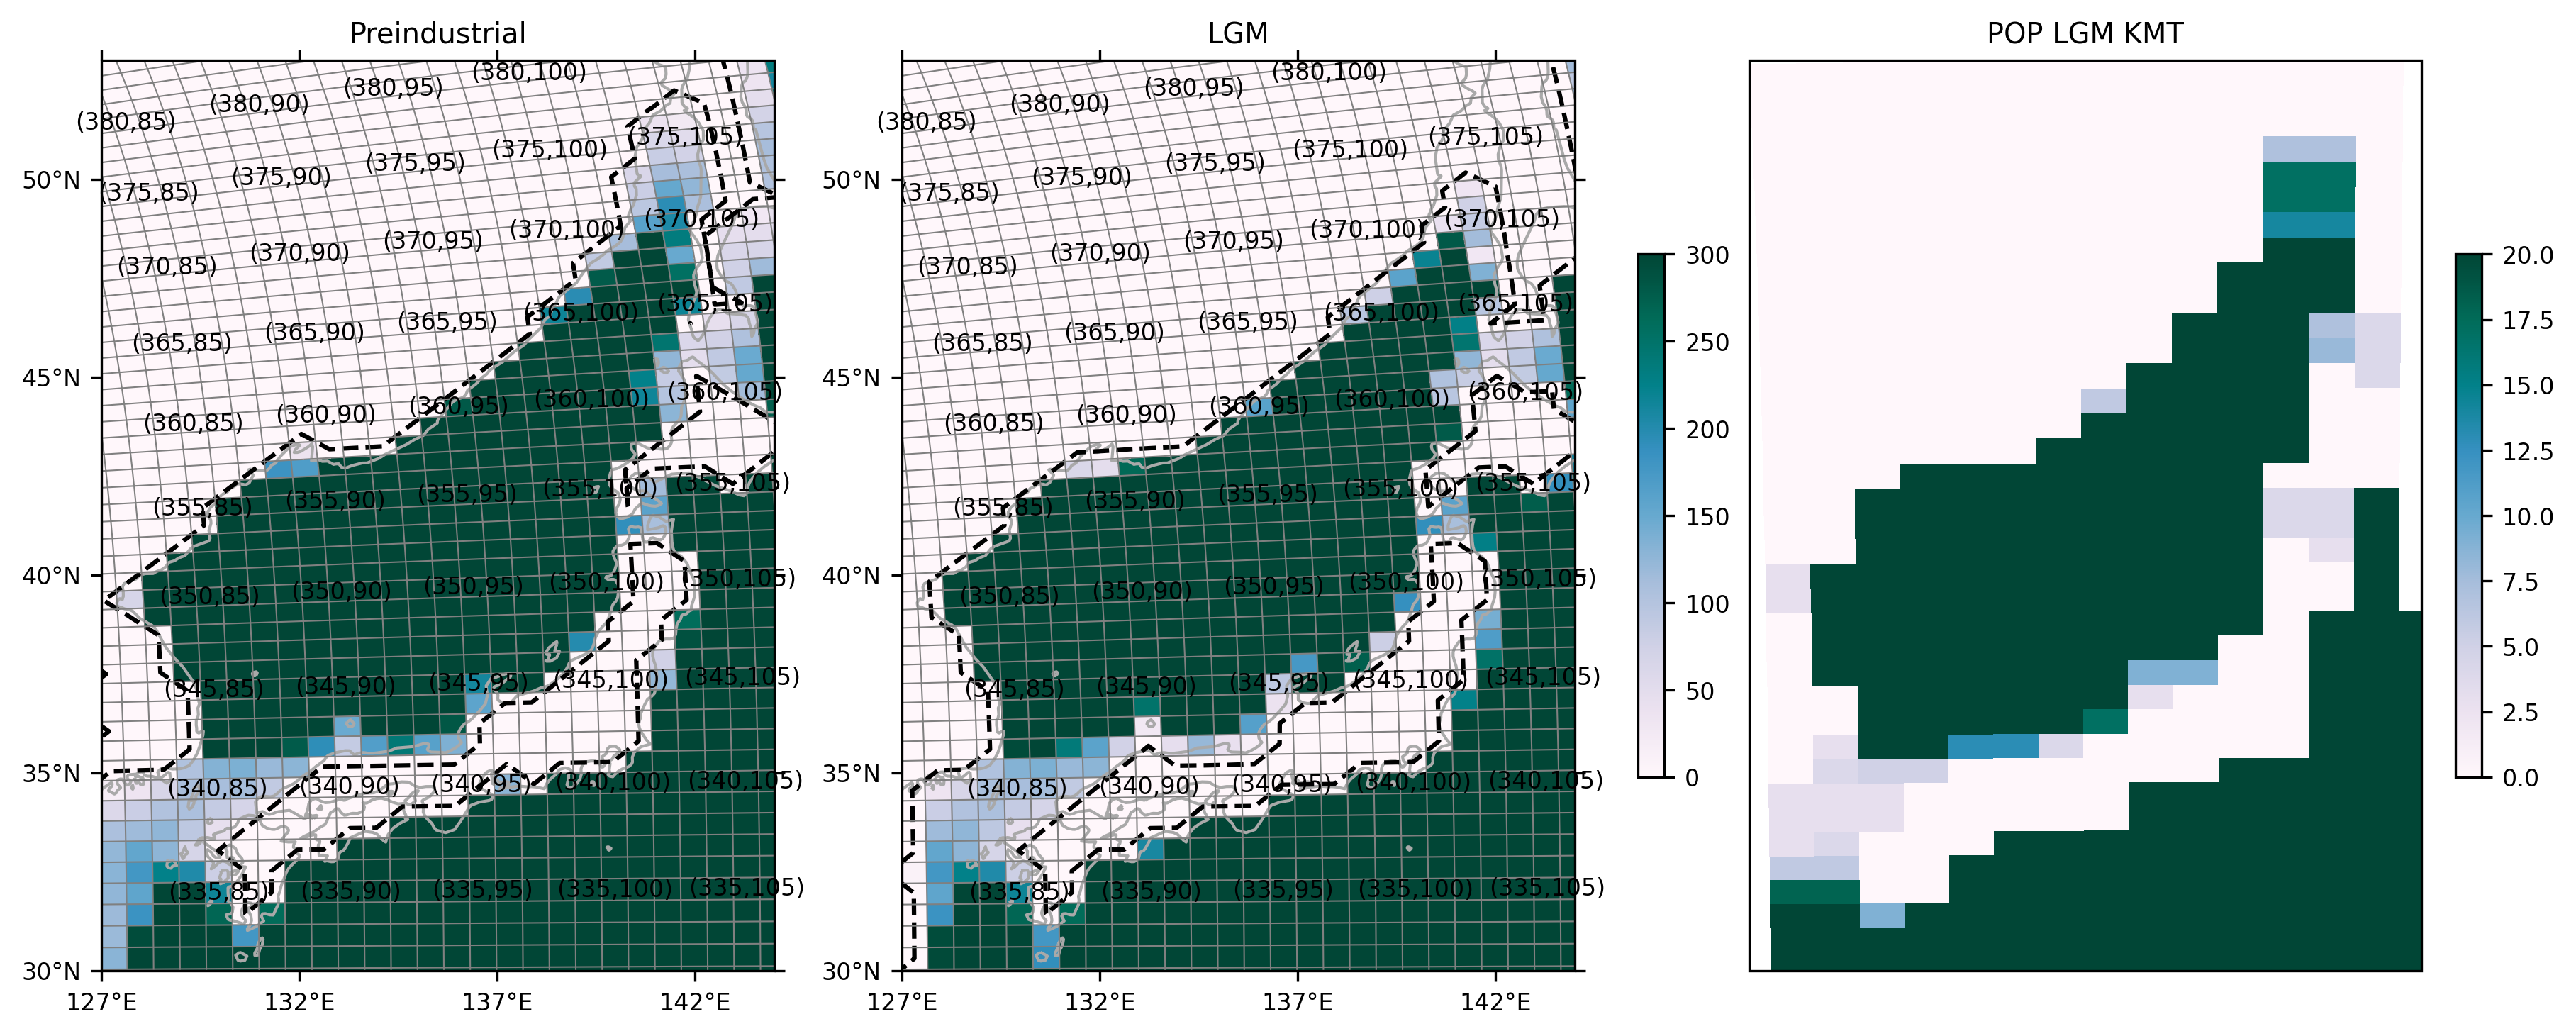

In [22]:
lonbeg = -233
lonend = -216
latbeg = 30
latend = 53

# get back Sea of Japan using values before filling holes
depth_21ka = replace_depth_box(depth_21ka, depth_glac, [340, 374], [81, 105])

# get back the south, central, and north channels using preindustrial
ds_mom_modi = replace_depth_box(depth_21ka, depth_prei, [333, 342], [82, 89])
ds_mom_modi = replace_depth_box(depth_21ka, depth_prei, [352, 355], [100, 103])
ds_mom_modi = replace_depth_box(depth_21ka, depth_prei, [361, 364], [103, 107])

plot_depth(depth_prei, depth_21ka, 'Preindustrial', 'LGM',
           ds_mom_prei, ds_pop_21ka,
           lonbeg, lonend, latbeg, latend, skip=5)

### Step 4.2: Get back Red Sea

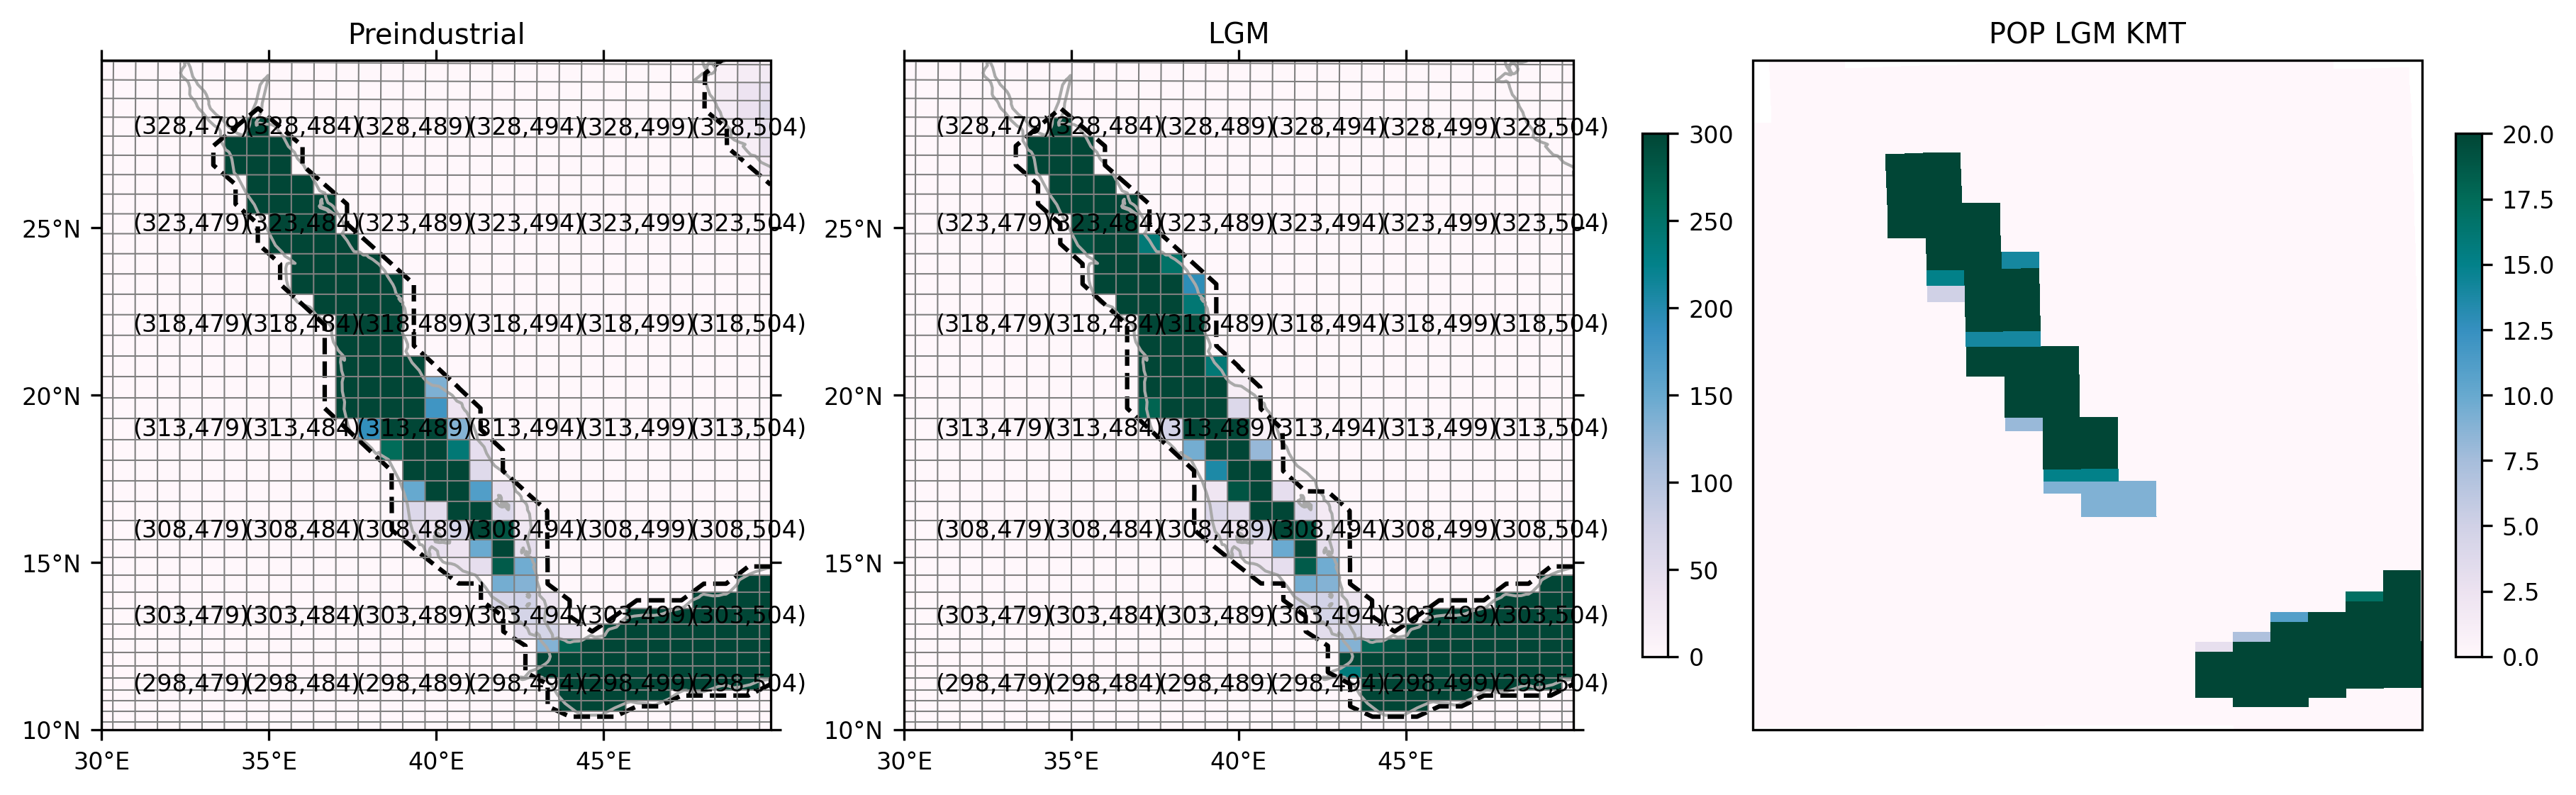

In [23]:
lonbeg = 30
lonend = 50
latbeg = 10
latend = 30

# get back Read Sea using values before filling holes
ds_mom_modi = replace_depth_box(depth_21ka, depth_glac, [303, 333], [475, 495])

# get back the channel using preindustrial
ds_mom_modi = replace_depth_box(depth_21ka, depth_prei, [300, 310], [489, 497])

plot_depth(depth_prei, depth_21ka, 'Preindustrial', 'LGM',
           ds_mom_prei, ds_pop_21ka,
           lonbeg, lonend, latbeg, latend, skip=5)

### Step 4.3: Get back Black Sea

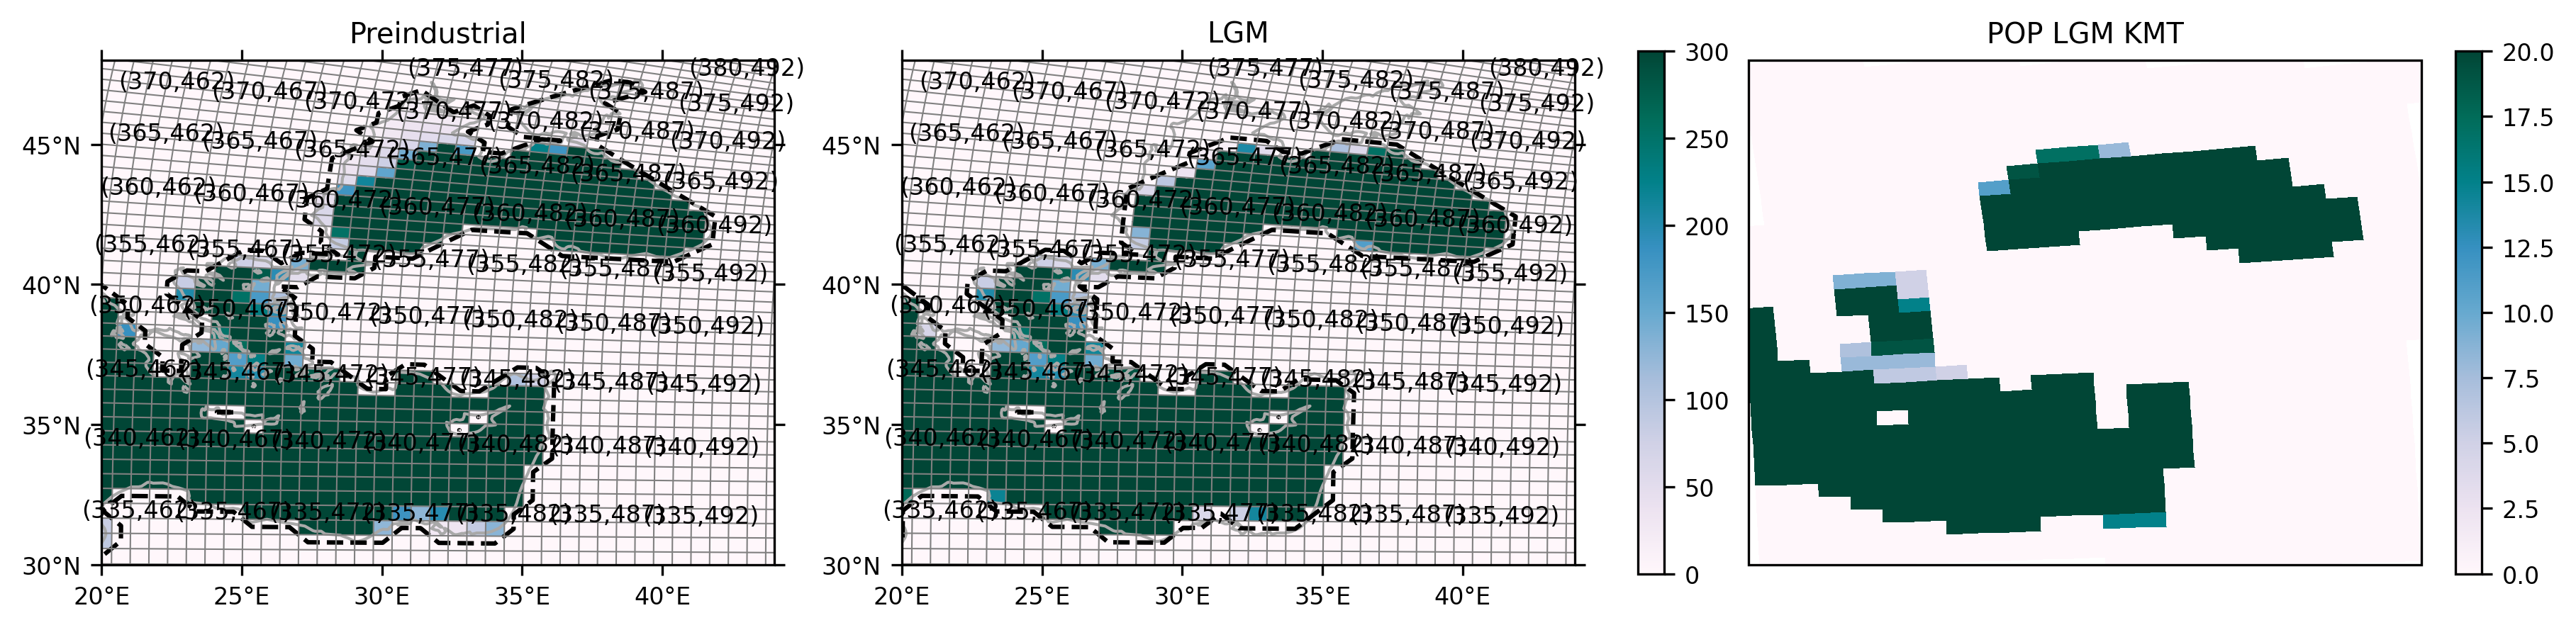

In [24]:
lonbeg = 20
lonend = 44
latbeg = 30
latend = 48

# get back Black Sea using values before filling holes
ds_mom_modi = replace_depth_box(depth_21ka, depth_glac, [350, 375], [467, 498])

# get back the channel using preindustrial
ds_mom_modi = replace_depth_box(depth_21ka, depth_prei, [344, 357], [464, 474])

plot_depth(depth_prei, depth_21ka, 'Preindustrial', 'LGM',
           ds_mom_prei, ds_pop_21ka,
           lonbeg, lonend, latbeg, latend, skip=5)

### Step 4.4: examine Sanda and Sahul shelves

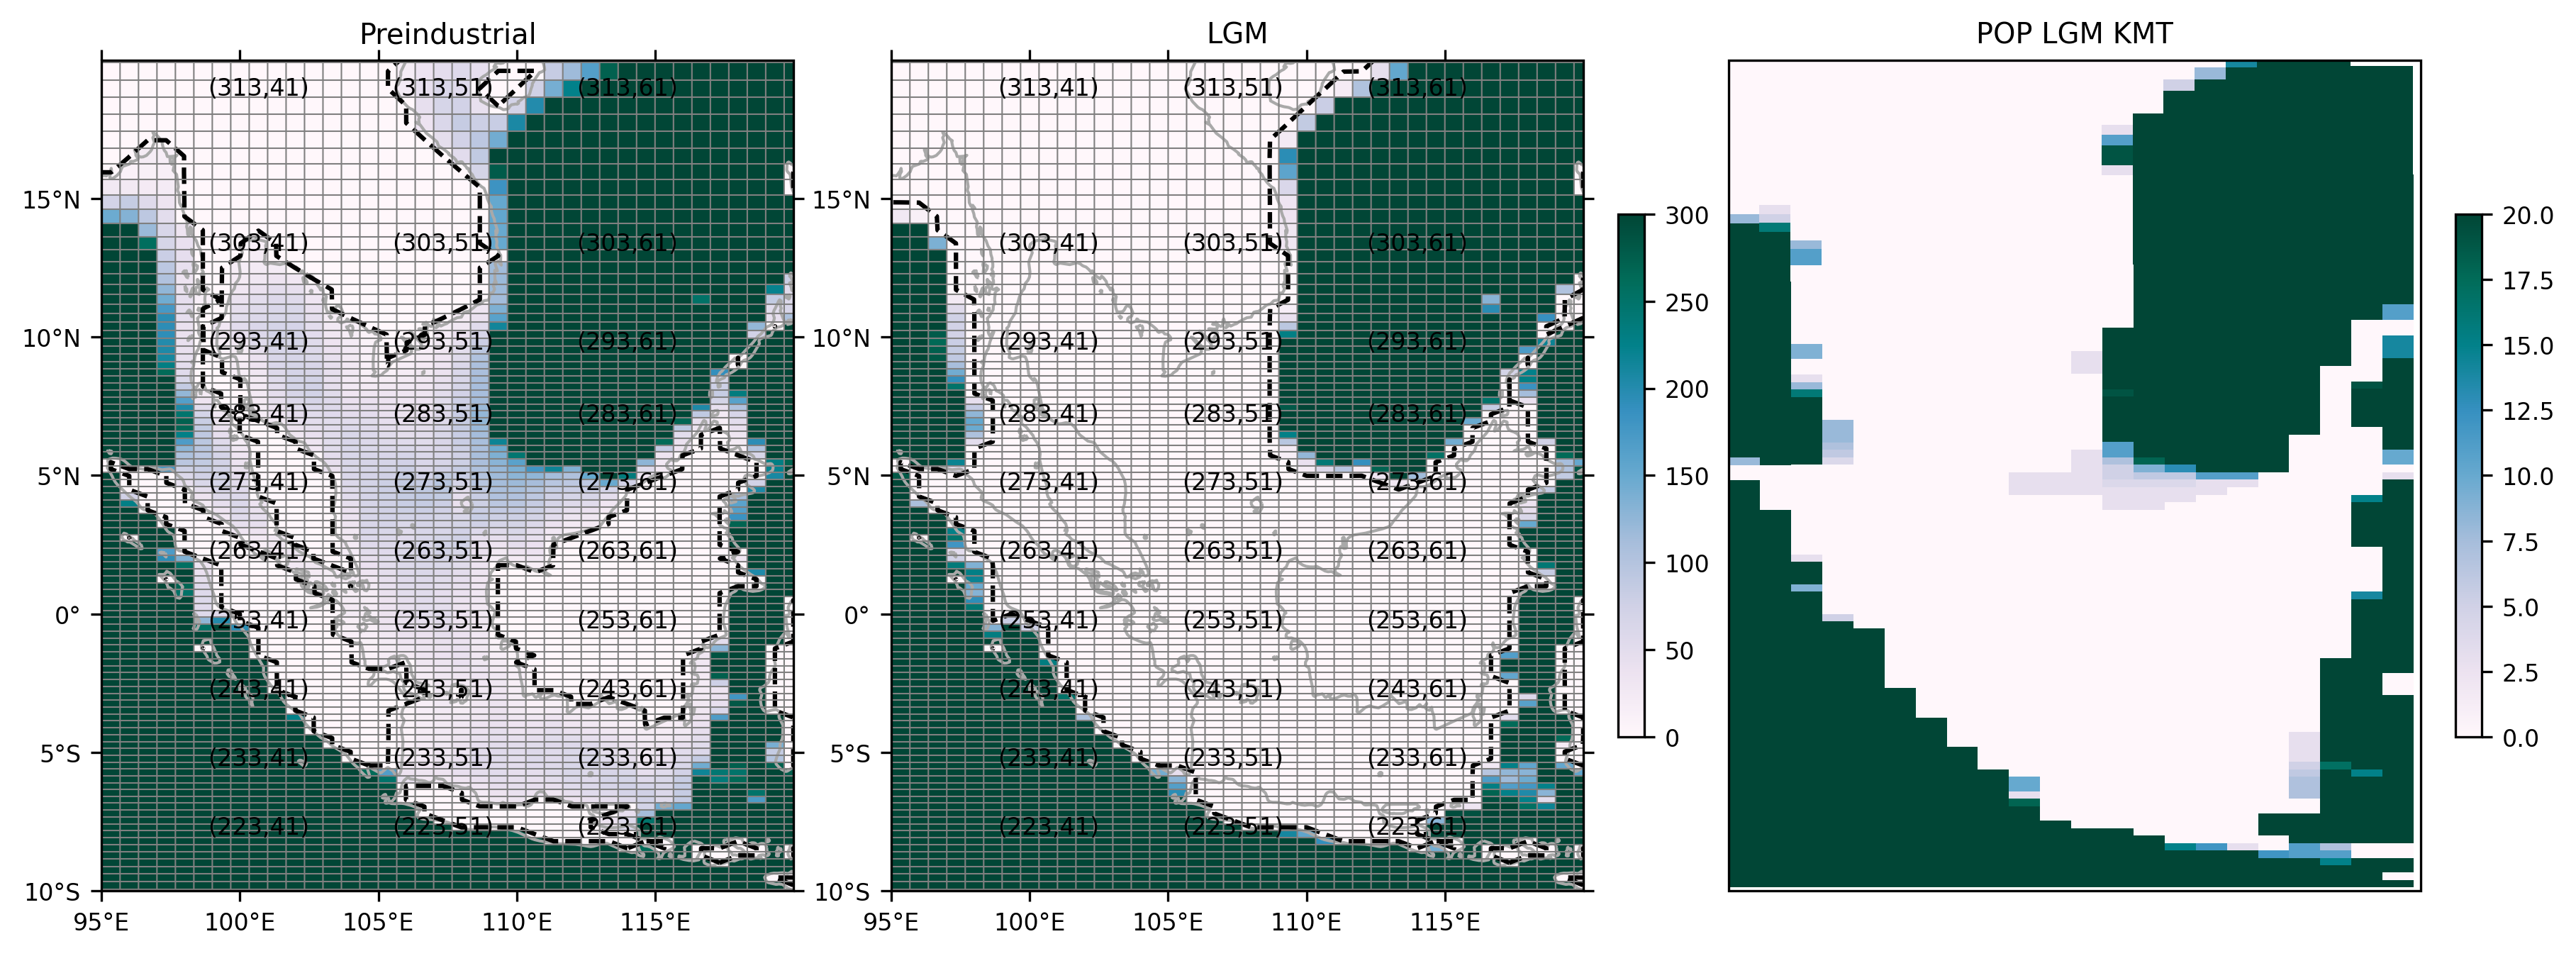

In [25]:
lonbeg = -265
lonend = -240
latbeg = -10
latend = 20

plot_depth(depth_prei, depth_21ka, 'Preindustrial', 'LGM',
           ds_mom_prei, ds_pop_21ka,
           lonbeg, lonend, latbeg, latend, skip=10)

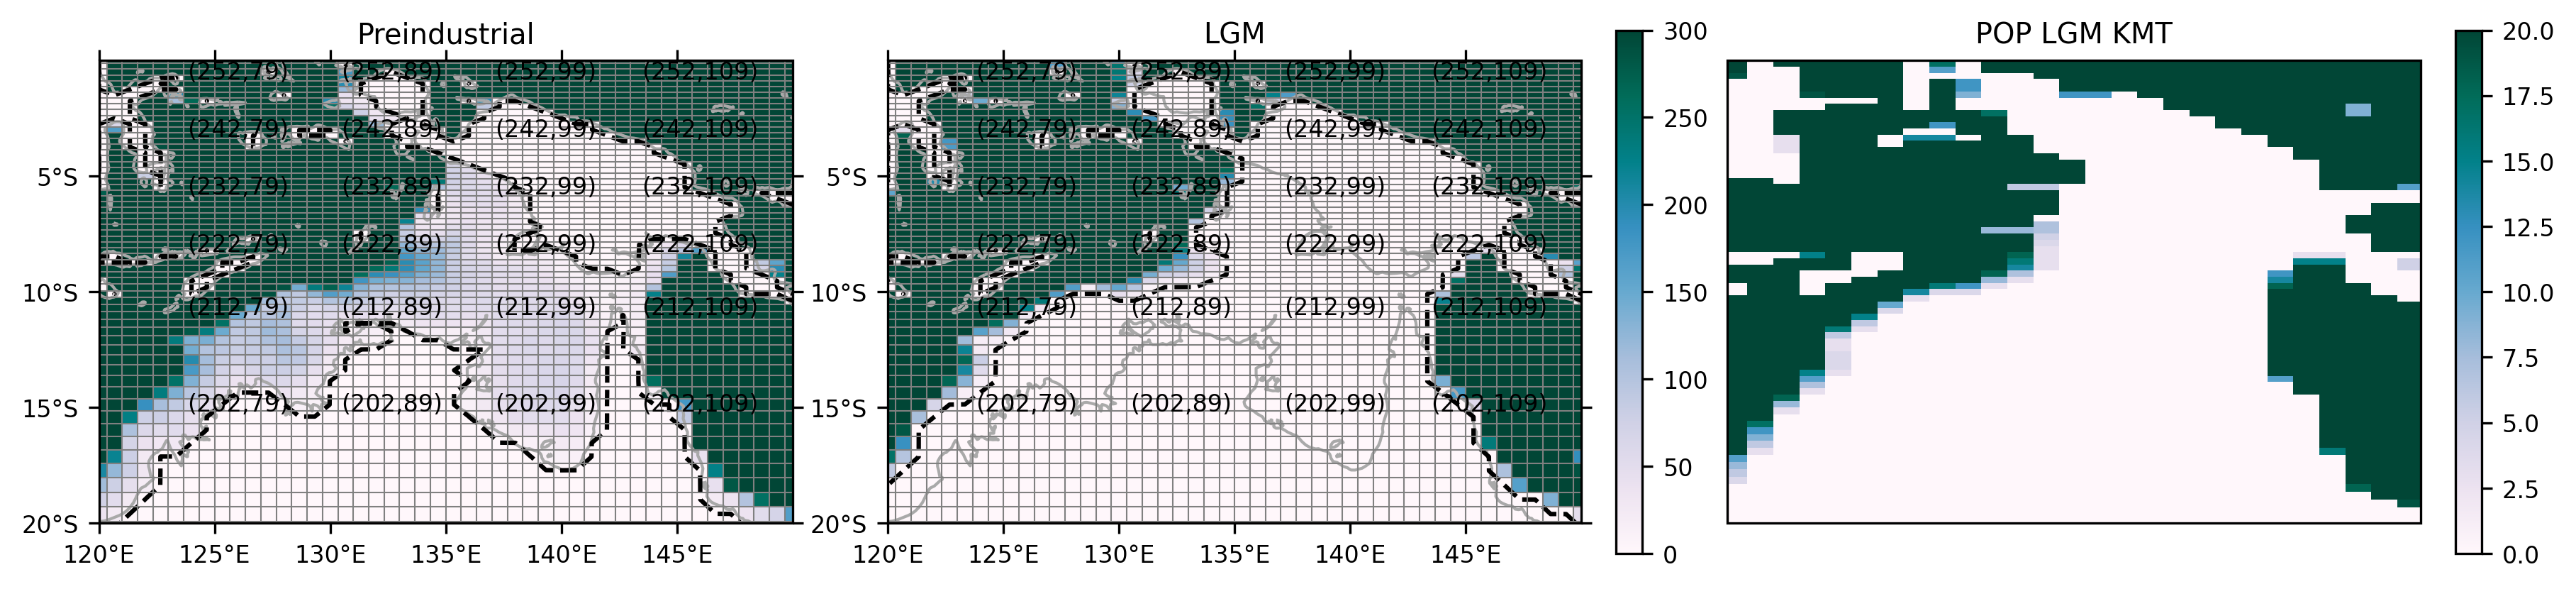

In [26]:
lonbeg = -240
lonend = -210
latbeg = -20
latend = 0

plot_depth(depth_prei, depth_21ka, 'Preindustrial', 'LGM',
           ds_mom_prei, ds_pop_21ka,
           lonbeg, lonend, latbeg, latend, skip=10)

### Step 4.5 Check again

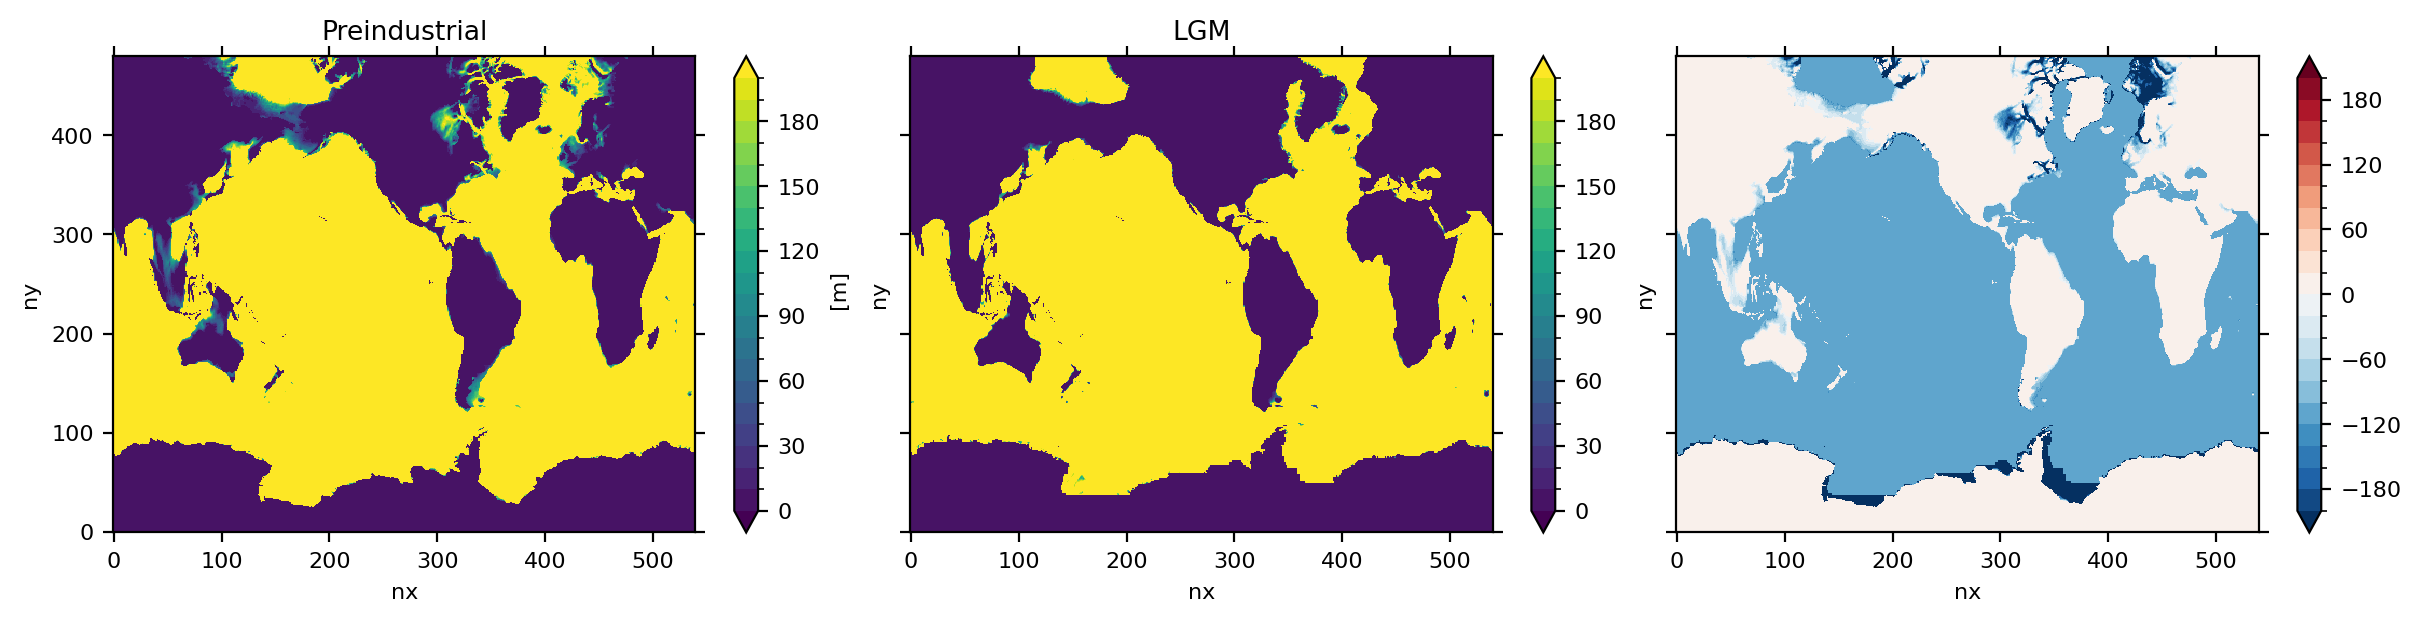

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=200,
                         sharex=True, sharey=True,
                         constrained_layout=True)

for var, title, ax in zip((depth_prei, depth_21ka),
                          ('Preindustrial', 'LGM'),
                          axes):
    var.plot(ax=ax, levels=np.linspace(0, 200, 21),
             extend='both')
    ax.set_title(title)

(depth_21ka - depth_prei).plot.pcolormesh(ax=axes[2],
                                         levels=np.linspace(-200, 200, 21),
                                         cmap='RdBu_r',
                                         extend='both')

### Step 5: Save a suite of files required for setting up CESM3

In [28]:
%%time

depth_21ka = xr.where(depth_21ka >= topo_min_depth, depth_21ka, 0)
topo.depth = depth_21ka

topo.write_topo(mom_topog_21ka, title='LGM bathymetry file for MOM6 by Jiang Zhu (jiangzhu@ucar.edu; https://github.com/NCAR/paleowg-recipes/cesm3)')
topo.write_esmf_mesh(mom_mesh_21ka, title='LGM ESMF mesh file for MOM6 by Jiang Zhu (jiangzhu@ucar.edu; https://github.com/NCAR/paleowg-recipes/cesm3)')
topo.write_scrip_grid(mom_scrip_21ka, title='LGM SCRIP file for MOM6 by Jiang Zhu (jiangzhu@ucar.edu; https://github.com/NCAR/paleowg-recipes/cesm3)')
topo.write_cice_grid(cice_grid_21ka)

CPU times: user 1.36 s, sys: 72.4 ms, total: 1.43 s
Wall time: 1.92 s
